In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

This notebook is a guide for the reconstruction analysis of the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [Spatial aggregation of error](#first-subbullet)
* [Temporal aggregation of error](#second-subbullet)
* [Latent space analysis](#third-subbullet)

In [21]:
from data_provider.data_provider import DataProvider
from models.linear import linear
from trainer.Filler import Filler

from types import SimpleNamespace

from evaluation.evaluation import statistical_comparison, autocorrelation, seasonal_analysis

In [22]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 50
data_kwargs.mask_length = 24*7*10
data_kwargs.mask_proba = 0.5
data_kwargs.window = 24
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
clean_data = data_provider.dataset.data
corrupted_data = data_provider.dataset.corrupted_data
mask = data_provider.dataset.mask

model_kwargs = dict(seq_dim=data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(linear, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/linear.pt')

device:  cpu
device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


In [23]:
reconstructed_data = filler.reconstruct(corrupted_data, mask)

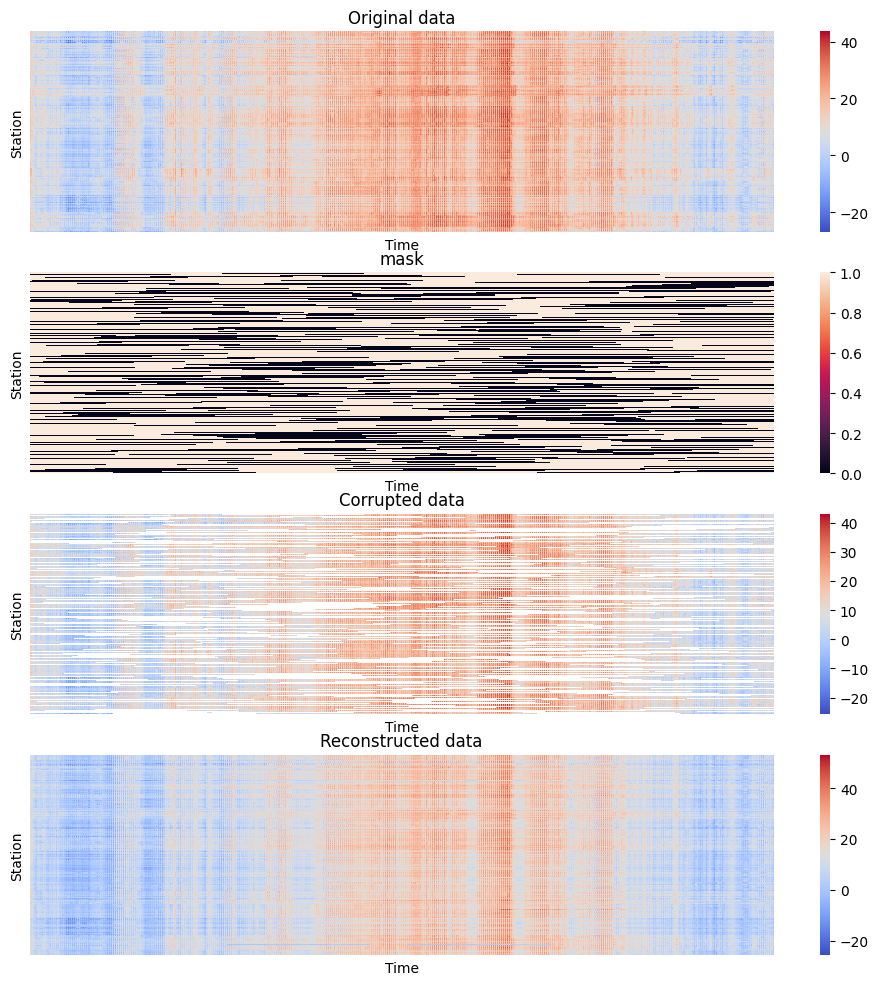

In [24]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
sns.heatmap(clean_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(mask.T, xticklabels=False, yticklabels=False, ax=ax[1])
ax[1].set_title("mask")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
sns.heatmap(corrupted_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[2])
ax[2].set_title("Corrupted data")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Station")
sns.heatmap(reconstructed_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[3])
ax[3].set_title("Reconstructed data")
ax[3].set_xlabel("Time")
ax[3].set_ylabel("Station")
plt.show()

In [25]:
stats = statistical_comparison(reconstructed_data, clean_data)

,Metric,Original Data,Imputed Data (GRIN)
0,count,8761.000000,8761.000000
1,mean,13.511994,13.881645
2,std,8.552649,8.344489
3,min,-6.112284,-4.600000
4,25%,7.078842,7.800000
5,50%,12.890828,13.200000
6,75%,19.443079,19.600000
7,max,39.299999,39.299999


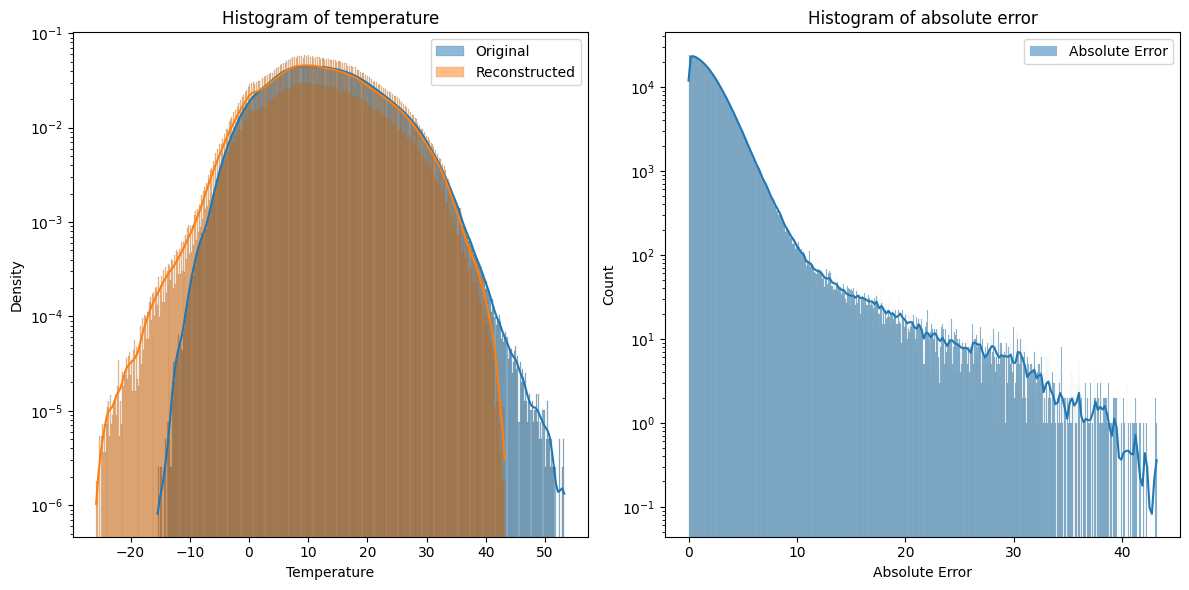

In [26]:
original_station_temp = reconstructed_data[np.where(~mask)]
reconstructed_station_temp = reconstructed_data[np.where(mask)]
absolute_error = np.abs(reconstructed_data - clean_data)[np.where(~mask)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(original_station_temp, label='Original', kde=True, stat="density", ax=ax[0])
sns.histplot(reconstructed_station_temp, label='Reconstructed', kde=True, stat="density", ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title("Histogram of temperature")
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel("Density")
ax[0].legend()
sns.histplot(absolute_error, label='Absolute Error', kde=True, ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title("Histogram of absolute error")
ax[1].set_xlabel("Absolute Error")
ax[1].set_ylabel("Count")
ax[1].legend()
plt.tight_layout()
plt.show()

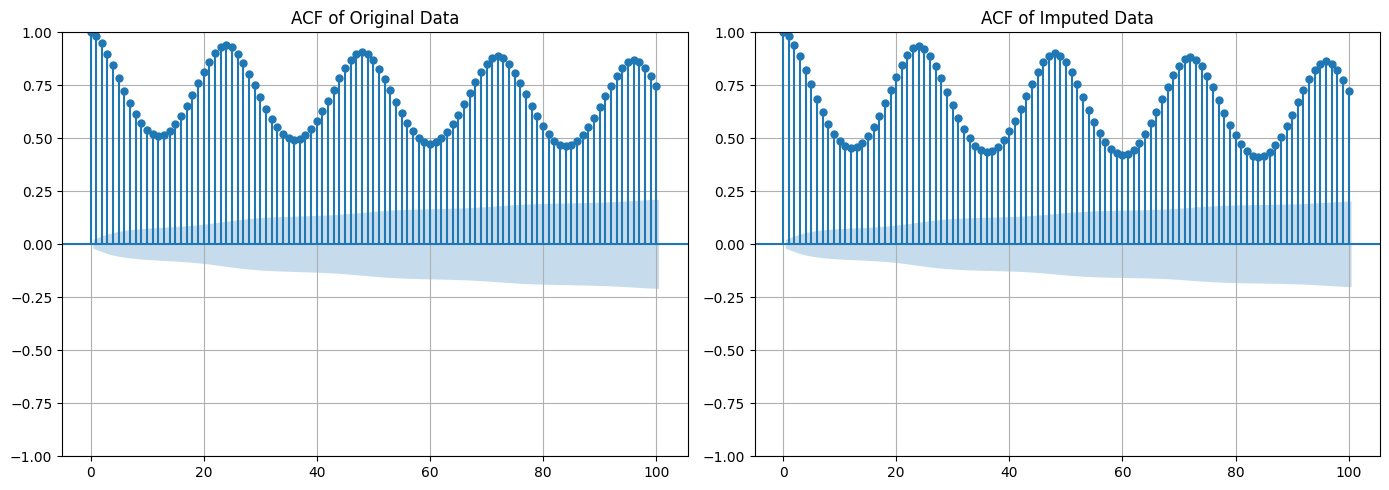

In [27]:
autocorrelation(reconstructed_data, clean_data)

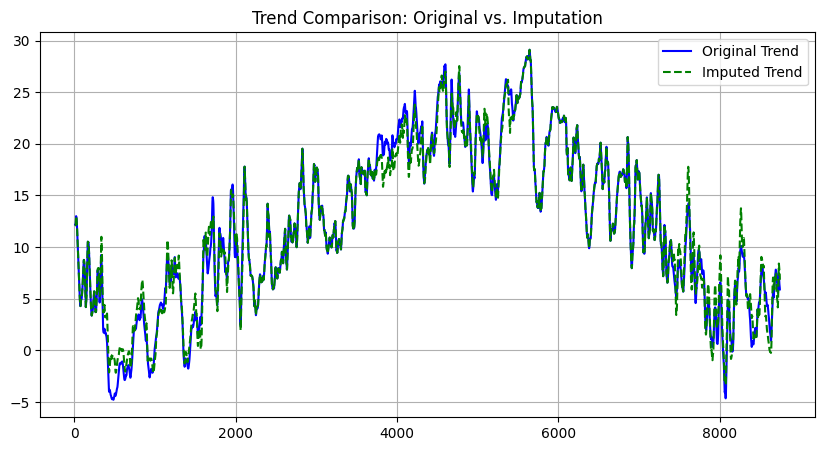

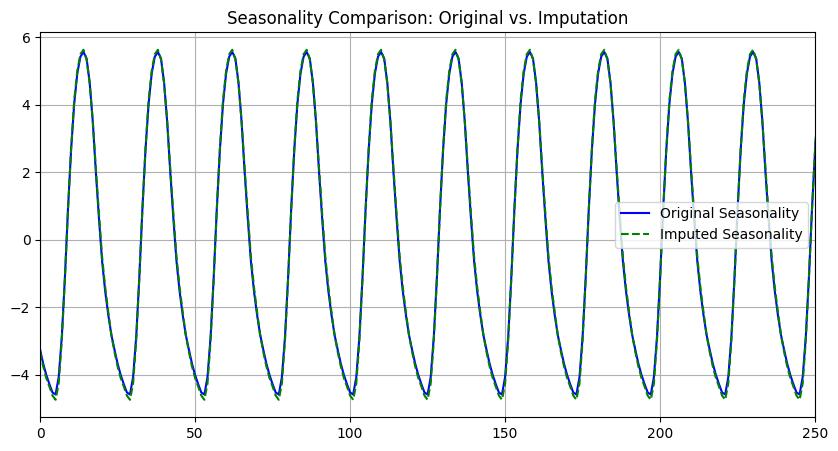

In [28]:
seasonal_analysis(reconstructed_data, clean_data)

### Spatial aggregation of error <a class="anchor" id="first-bullet"></a>

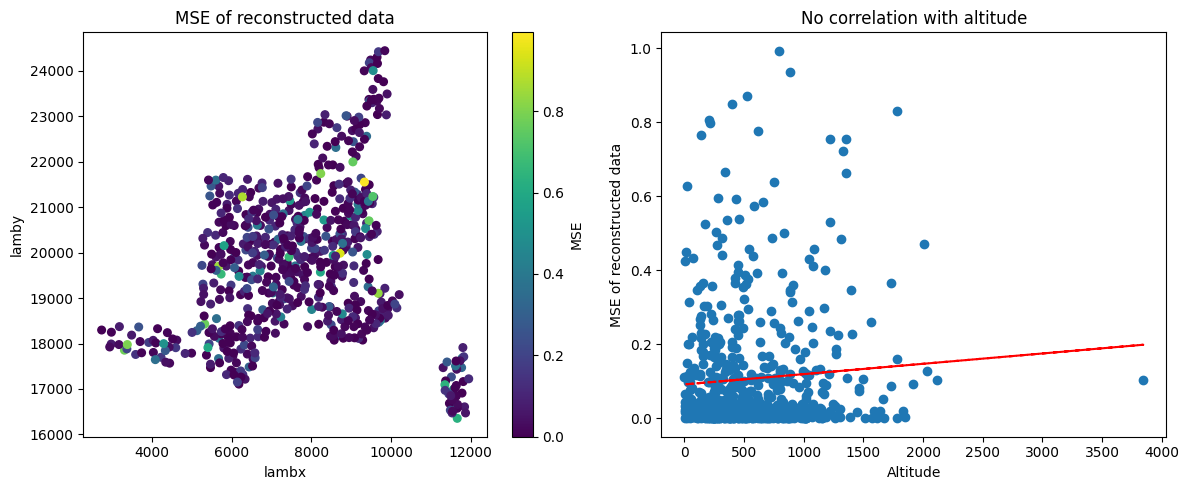

In [29]:
spatial_MSE = torch.square(torch.mean(reconstructed_data - clean_data, dim=0))
coords = [data_provider.data.predictors['lambx'].values, data_provider.data.predictors['lamby'].values]
altitude = data_provider.data.predictors['ZS'].values

treshold = 1
loc_aberrations = np.where(spatial_MSE > treshold)
spatial_MSE = spatial_MSE[np.where(spatial_MSE<treshold)]
coords = [coords[0][np.where(spatial_MSE<treshold)], coords[1][np.where(spatial_MSE<treshold)]]
altitude = altitude[np.where(spatial_MSE<treshold)]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(coords[0], coords[1], c=spatial_MSE, cmap='viridis', s=30)
plt.colorbar(ax[0].collections[0], ax=ax[0], label='MSE')
ax[0].set_title('MSE of reconstructed data')
ax[0].set_xlabel('lambx')
ax[0].set_ylabel('lamby')
ax[1].scatter(altitude, spatial_MSE)
# linear fit 
z = np.polyfit(altitude, spatial_MSE, 1)
p = np.poly1d(z)
ax[1].plot(altitude, p(altitude), "r--", label='Linear fit')
ax[1].set_xlabel('Altitude')
ax[1].set_ylabel('MSE of reconstructed data')
ax[1].set_title('No correlation with altitude')
plt.tight_layout()
plt.show()

In [30]:
import seaborn as sns
from io import BytesIO
from PIL import Image
import cv2
from tqdm import tqdm

In [31]:
coords = [data_provider.data.predictors['lambx'].values, data_provider.data.predictors['lamby'].values]

frames = []
for i in tqdm(range(100)):
    data = clean_data[i]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(coords[0], coords[1], c=data, cmap='coolwarm', s=30, vmin=-10, vmax=20)
    plt.colorbar(ax.collections[0], ax=ax, label='Temperature')
    ax.set_xlabel("lambx")
    ax.set_ylabel("lamby")
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf)
    frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    frames.append(frame)

# save video
height, width, _ = frames[0].shape
video = cv2.VideoWriter('spatial_temperature.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))
for frame in frames:
    video.write(frame)
video.release()


absolute_error = np.abs(reconstructed_data - clean_data)
frames = []
for i in tqdm(range(100)):
    data = absolute_error[i]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(coords[0], coords[1], c=data, cmap='RdYlGn_r', s=30, vmin=0, vmax=8)
    plt.colorbar(ax.collections[0], ax=ax, label='absolute error')
    ax.set_xlabel("lambx")
    ax.set_ylabel("lamby")
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf)
    frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    frames.append(frame)

# save video
height, width, _ = frames[0].shape
video = cv2.VideoWriter('spatial_error.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))
for frame in frames:
    video.write(frame)
video.release()

100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


### Temporal aggregation of error <a class="anchor" id="second-bullet"></a>

In [32]:
from data_provider.data_provider import DataProvider
from models.linear import linear
from models.MLP import MLP
from trainer.Filler import Filler

from types import SimpleNamespace

In [40]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'PatchMaskDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 50
data_kwargs.mask_length = 24*7*10
data_kwargs.mask_proba = 0.9
data_kwargs.treshold_time = 0.25

data_provider = DataProvider(data_kwargs)
clean_data = data_provider.dataset.data
corrupted_data = data_provider.dataset.corrupted_data
mask = data_provider.dataset.mask

device:  cpu


In [41]:
model_kwargs = dict(seq_dim=data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba
filler = Filler(linear, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/linear.pt')
linear_reconstructed_data = filler.reconstruct(corrupted_data, mask)

model_kwargs = dict(seq_dim=data_provider.data.n_nodes, hidden_dim=2*data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba
filler = Filler(MLP, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/MLP.pt')
MLP_reconstructed_data = filler.reconstruct(corrupted_data, mask)

model_kwargs = dict(seq_dim=data_provider.data.n_nodes, hidden_dim=int(0.25*data_provider.data.n_nodes))
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba
filler = Filler(MLP, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/autoencoder.pt')
autoencoder_reconstructed_data = filler.reconstruct(corrupted_data, mask)

device:  cpu
device:  cpu
device:  cpu


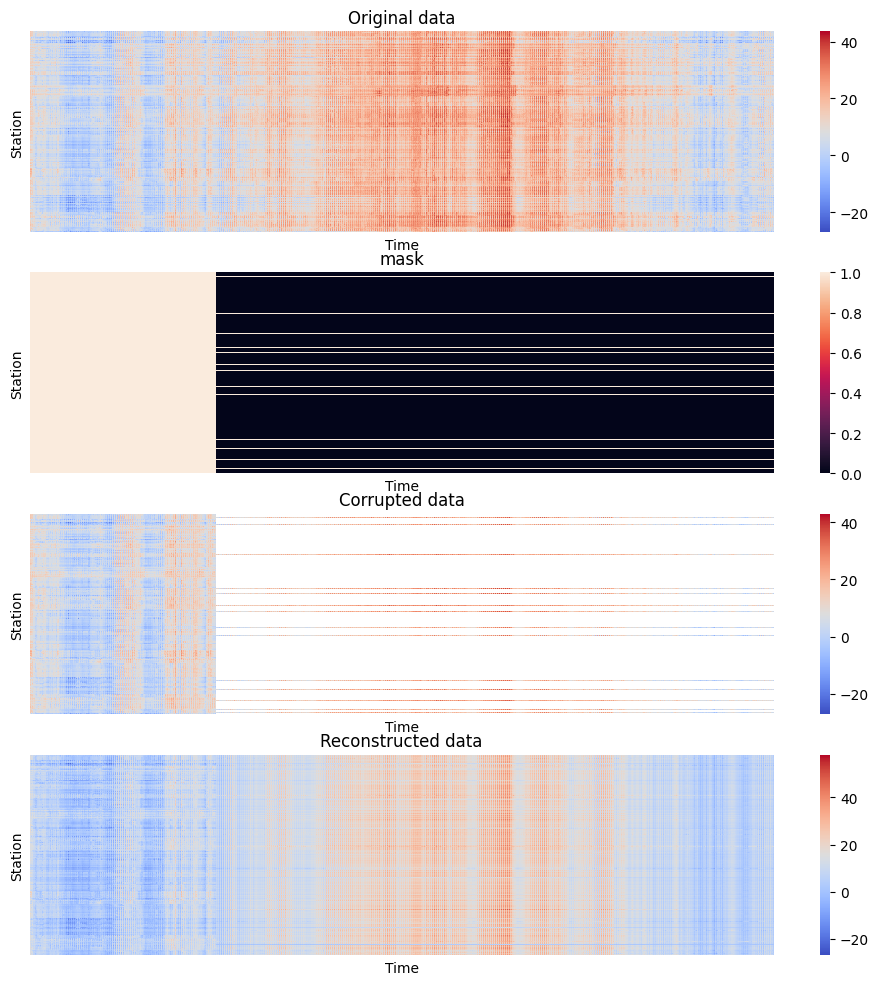

In [42]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
sns.heatmap(clean_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(mask.T, xticklabels=False, yticklabels=False, ax=ax[1])
ax[1].set_title("mask")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
sns.heatmap(corrupted_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[2])
ax[2].set_title("Corrupted data")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Station")
sns.heatmap(linear_reconstructed_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[3])
ax[3].set_title("Reconstructed data")
ax[3].set_xlabel("Time")
ax[3].set_ylabel("Station")
plt.show()

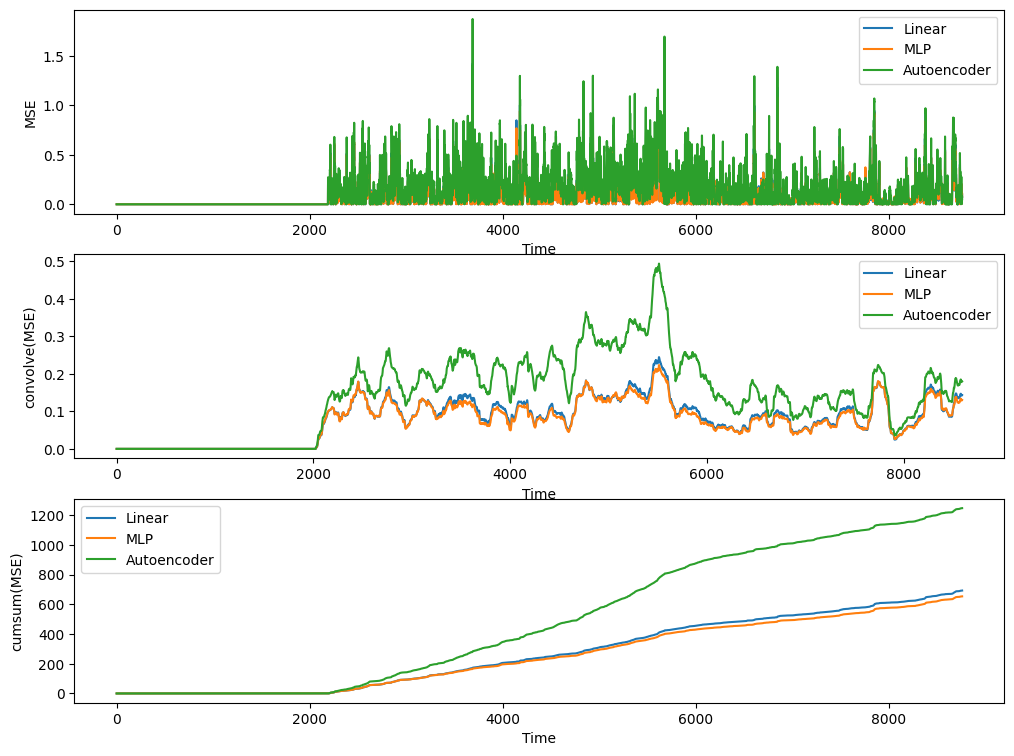

In [43]:
linear_temporal_MSE = torch.square(torch.mean(linear_reconstructed_data - clean_data, axis=1))
MLP_temporal_MSE = torch.square(torch.mean(MLP_reconstructed_data - clean_data, axis=1))
autoencoder_temporal_MSE = torch.square(torch.mean(autoencoder_reconstructed_data - clean_data, axis=1))

window_size = 24*7
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
ax[0].plot(linear_temporal_MSE, label='Linear')
ax[0].plot(MLP_temporal_MSE, label='MLP')
ax[0].plot(autoencoder_temporal_MSE, label='Autoencoder')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('MSE')
ax[0].legend()
ax[1].plot(np.convolve(linear_temporal_MSE, np.ones(window_size)/window_size, mode='valid'), label='Linear')
ax[1].plot(np.convolve(MLP_temporal_MSE, np.ones(window_size)/window_size, mode='valid'), label='MLP')
ax[1].plot(np.convolve(autoencoder_temporal_MSE, np.ones(window_size)/window_size, mode='valid'), label='Autoencoder')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('convolve(MSE)')
ax[1].legend()
ax[2].plot(np.cumsum(linear_temporal_MSE), label='Linear')
ax[2].plot(np.cumsum(MLP_temporal_MSE), label='MLP')
ax[2].plot(np.cumsum(autoencoder_temporal_MSE), label='Autoencoder')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('cumsum(MSE)')
ax[2].legend()
plt.show()

### Latent space analysis <a class="anchor" id="third-bullet"></a>

In [44]:
from data_provider.data_provider import DataProvider
from models.linear import linear
from trainer.Filler import Filler

from types import SimpleNamespace

In [45]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 50
data_kwargs.mask_length = 24*7*3
data_kwargs.mask_proba = 0.5
data_kwargs.window = 24
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
train_dataloader = data_provider.train_dataloader()
corrupted_data = data_provider.dataset.data
mask = data_provider.dataset.mask

model_kwargs = dict(seq_dim=data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 10
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(linear, model_kwargs, filler_kwargs)

device:  cpu
device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


In [46]:
train_loss = filler.latent_training(train_dataloader=train_dataloader, data=corrupted_data, mask=mask)

start mini training for latent space analysis
Epoch 1/10, Loss: 20.32780814, time: 0.24s
Epoch 2/10, Loss: 11.90943050, time: 5.71s
Epoch 3/10, Loss: 7.53617549, time: 11.29s
Epoch 4/10, Loss: 5.53287816, time: 16.74s
Epoch 5/10, Loss: 4.69063818, time: 22.19s
Epoch 6/10, Loss: 4.29776907, time: 28.04s
Epoch 7/10, Loss: 4.10332596, time: 33.24s
Epoch 8/10, Loss: 3.97466993, time: 38.58s
Epoch 9/10, Loss: 3.81807268, time: 43.82s
Epoch 10/10, Loss: 3.62044501, time: 49.06s


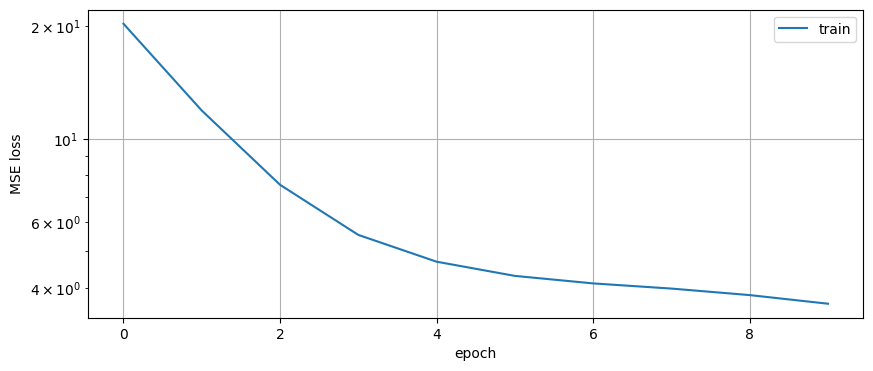

In [47]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()